In [1]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import ls_utils as utils
import lens_plot
import HOD

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
h = 0.7
___PLOT_FOR_KEYNOTE___ = 1

M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.arange(0.  , 2.4 , 0.1)
zs_array    = np.arange(0.  , 5.4 , 0.2)
min_SNR     = 20
arc_mu_thr  = 3

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


[-25.65668051 -22.65668051]
Vol: 8.5e+10 | N: 6.4e+05


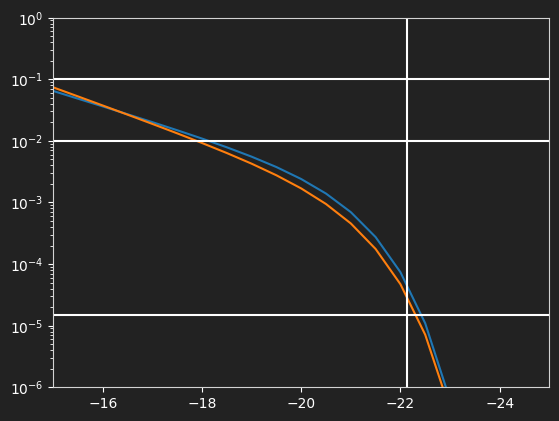

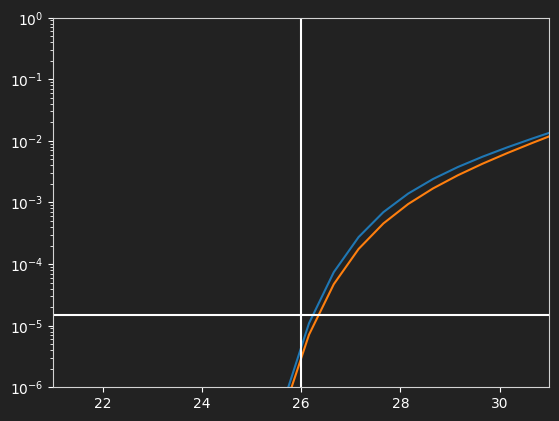

In [11]:
zs = 3.5

M_array = np.linspace(-15 , -27 , 25)
corr = 5 * np.log10(cosmo.luminosity_distance(zs).value * 1e5) + ls.K_correction(zs, 'ukirt_wfcam_H', 'sdss_g0', M_array)
m_array = M_array + corr
print((23, 26) - corr[0])

vol = ls.Lens_cone_volume_diff(3.5, 15_000, dz=0.5)
n   = 1.5e-5 * 0.5
print(f'Vol: {vol:.1e} | N: {n * vol:.1e}')

plt.plot(M_array, ls.schechter_LF(M_array, 3))
plt.plot(M_array, ls.schechter_LF(M_array, 4))
plt.yscale('log')
plt.xlim((-15,-25))
plt.ylim((1e-6,1))
plt.axvline(-22.12758499)
plt.axhline(1.5e-5)

plt.axhline(1e-1)
plt.axhline(1e-2)
plt.show()

plt.plot(m_array, ls.schechter_LF(M_array, 3))
plt.plot(m_array, ls.schechter_LF(M_array, 4))
plt.yscale('log')
plt.xlim((21,31))
plt.ylim((1e-6,1))
plt.axvline(26)
plt.axhline(1.5e-5)
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)       |

|      EUCLID Wide H      |           0.360|     15000.000|         24.5|         25.0|          12|  1.8e+05 (  5.4e+04)|

Between 3<z<4 : 226.6 (77.9)


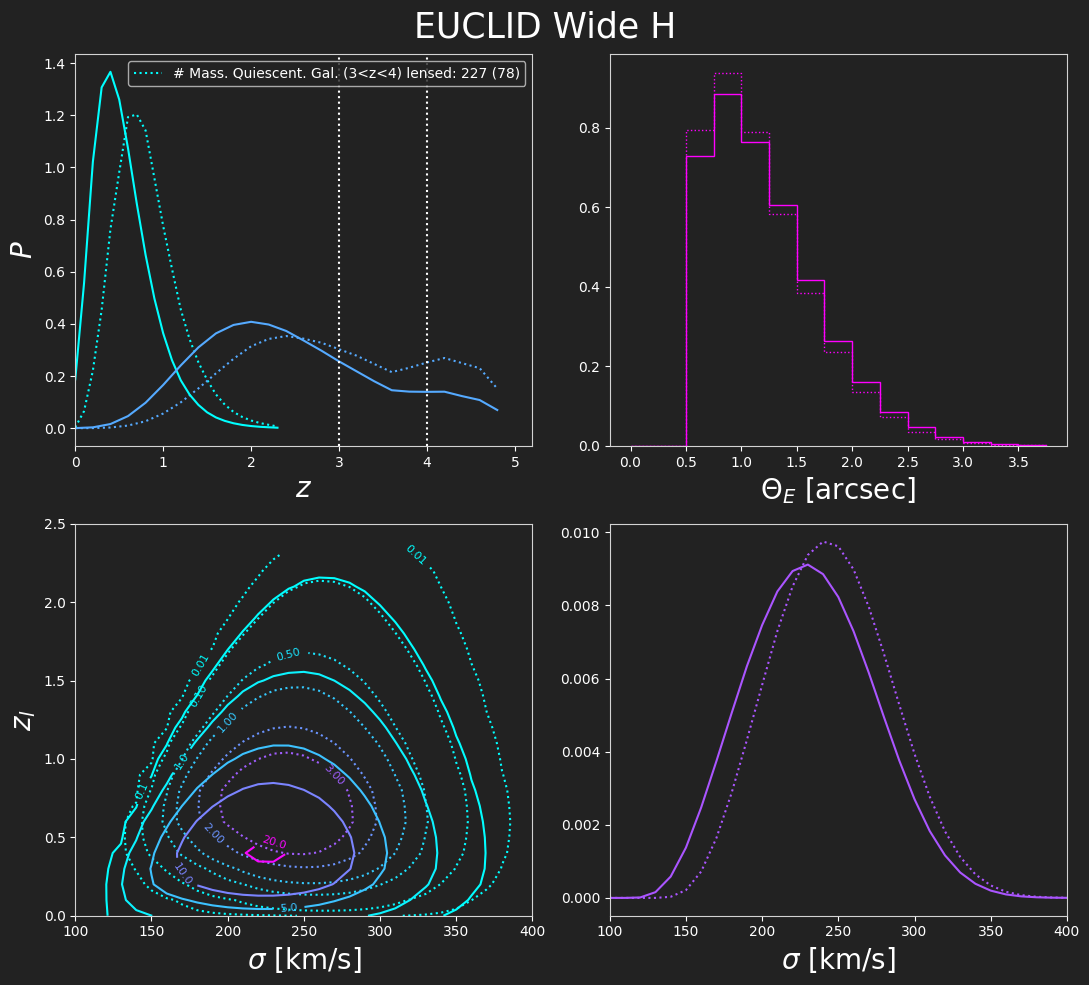

In [10]:
title = 'EUCLID Wide H'
survey_params = utils.read_survey_params(title, VERBOSE = 0)
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

def LF_uniform_massive_quiescent(M_int, zs): 
    return 1.5e-6 * np.ones(len(M_int))

LF = LF_uniform_massive_quiescent if 1 else ls.schechter_LF
          
__zs_array__ = np.arange(0.  , 5 , 0.2)
__Mr_array__ = np.linspace(-22.5, -25.5, 50)
matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                            sigma_array, zl_array, __zs_array__, __Mr_array__, limit, area, 
                                                            seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                            photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                            LF_func = LF, restframe_band = 'sdss_g0',
                                                            LENS_LIGHT_FLAG = False, SIE_FLAG = True)      
matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                            sigma_array, zl_array, __zs_array__, __Mr_array__, limit, area, 
                                                            seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                            photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                            LF_func = LF, restframe_band = 'sdss_g0',
                                                            LENS_LIGHT_FLAG = True, SIE_FLAG = True)                                                                                                                                                                                  
utils.print_summary_surveys([title])
print(f'Between 3<z<4 : {np.sum(matrix_noLL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.1f} ({np.sum(matrix_LL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.1f})')
lens_plot.set_plt_param(PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.15, hspace=.2)
lens_plot.plot_z_sigma_distributions(fig, ax, title, zl_array,__zs_array__, sigma_array,
                            Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                            PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___, CONTOUR = 0, 
                            LOG = 0, SMOOTH = 1, SAVE = 1, LEGEND = 0)
ax[0,0].axvline(3, c='w', ls=':')
ax[0,0].axvline(4, c='w', ls=':')
ax[0,0].legend([f'# Mass. Quiescent. Gal. (3<z<4) lensed: {np.sum(matrix_noLL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.0f} ({np.sum(matrix_LL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.0f})'], fontsize=10)
plt.show()



In [40]:
print(f'Between 3<z<4 : {np.sum(matrix_noLL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.1f} ({np.sum(matrix_LL[np.logical_and(__zs_array__ > 3, __zs_array__ < 4 )][:][:]):.1f})')


Between 3<z<4 : 226.6 (77.9)


In [14]:
def integrand_Lens_cone_volume_diff(z):                #works only in a flat universe
    c_sp = 299792.458                                  #km/s
    Hz = cosmo.H(z).value                              #km s^-1 Mpc^-1
    return np.power(cosmo.angular_diameter_distance(z).value*(1+z),2)*(c_sp/Hz)

def Lens_cone_volume_diff(z, area_sq_degree, dz=0.5):  
    area_sterad = area_sq_degree*1/(57.2958**2)        #sterad 
    if(z-dz/2>0):
        return dz/2*(integrand_Lens_cone_volume_diff(z-dz/2)+integrand_Lens_cone_volume_diff(z+dz/2))*area_sterad
    else:
        return dz/4*(integrand_Lens_cone_volume_diff(z)+integrand_Lens_cone_volume_diff(z+dz/2))*area_sterad

Lens_cone_volume_diff(10.5, 35 / 3600, dz=1.5) * 0.85 / 1e3

68.97661926894668